# Regularizers as memory

_W. Evan Durno, 2022_

## Executive summary of current state 

Transfer learning, if properly realized, has the potential to move RL significantly closer to AGI. 
My current strategy to realize transfer learning is to mature our methods beyod _small learning rates_ and realize a 
mathemtically guaranteed optimum. To do this, I leverage the asymptotic equivalence of the MLE to the following.

$$ \hat \theta_{MLE} \to_{a.s.} \arg \max_\theta \frac{-1}{2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $$

With this information, we may pack all previously observed $n_1$ samples into this quadratic form regularizer 
centered around the $n_1^{th}$ estimate $\hat \theta_{n_1}$. 
Notice that the regularization term $\lambda$ is now exactly solvable.

$$ \hat \theta_{n_1+n_2} := \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_1+n_2} \log f_X(X_i;\theta) - \frac{n_1}{2n_2} (\theta - \hat \theta_0)^T \hat{\mathcal{I}}_{\theta_0} (\theta - \hat \theta_0) $$

Seredipitously, this analytically-derived memory 
- is a regularizer with known $\lambda = n_1/n_2$,
- and a produces universal sufficient statistics for all models meeting a few regularity requirements. 

To contend with computationally intractibility of $\hat{\mathcal{I}}_{\theta_0}$, we apply a Krylov method, extending the Lanczos algorithm.

Below, computational experiments demonstrate the method applied to reinforcement learning.

**CURRENT CHALLENGE:** reproducing results with more-complex models. I'm focussed on the CNN case. 

## impact

When combined with universal sufficient statistics, continuous transfer learning becomes particularly impactful. 
- My mathematically-guaranteed transfer learning mechanism leverages sufficient statistics to not require datasets to be distributed with models. 
Catestrophic forgetting can now be avoided merely by publishing sufficient statistics. 
- Packing arbitrarily large datasets into finite-dimensional sufficient statistics has a hardware _miniturization effect_, 
especially when combined with Krylov methods. 
Even if building a model requires an entire data center, it can be applied with significantly-less hardware. 
- Miniturization and sufficient statistics combine nicely to improve _RL in the real world_, 
because a data center may be leveraged to bootstrap a model into a near-real game. 
Then, agents can be deployed with miniturized models, making them effective with local compute. 
Further, because analytic memory is a regularizer, it'll maximize sampling efficiency by reducing the parameter space's effective dimension. 
For example, pick-and-place agents could be initialized digitally, then finished or forever-optimized 
with local compute on its small dataset of real-world observations. 

## analytic memory derivation 

Let our simple random sample have the following MLE.

$ \hat \theta = \arg \max_\theta \sum_{i=1}^n \log f_X(X_i; \theta) $ 

Break the sample into 2 parts, $n = n_1 + n_2$, where $n_1$ samples are to be memorized, and $n_2$ samples are new. 

$ = \arg \max_\theta \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_1 n_2} \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $

Expand the $n_1$ term with a Taylor series around $\theta_0$, so require $\theta$ near $\theta_0$. 

$ \approx \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_1 n_2} \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) $
$ + \frac{n_1}{n_1 n_2} (\theta - \theta_0)^T \nabla_\theta \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) $ 
$ + \frac{n_1}{n_1 n_2} 2^{-1}(\theta - \theta_0)^T \nabla_\theta \nabla_\theta^T \sum_{i=1}^{n_1} \log f_X(X_i; \theta_0) (\theta - \theta_0) $ 

Apply the strong law of large numbers, so require $n_1$ large. 

$ \approx \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) + \frac{n_1}{n_2} \mathbb{E} \log f_X(X_1; \theta_0) $
$ + \frac{n_1}{n_2} (\theta - \theta_0)^T \mathbb{E} \nabla_\theta \log f_X(X_1; \theta_0) $ 
$ + \frac{n_1}{n_2} 2^{-1}(\theta - \theta_0)^T \mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) (\theta - \theta_0) $

Set $\mathbb{E} \log f_X(X_1; \theta_0) = 0$ because it is constant under maximization over $\theta$, 
and recognize that $ \nabla_\theta \mathbb{E} \log f_X(X_1; \theta_0) = 0$. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $ 
$ + \frac{n_1}{n_2} 2^{-1}(\theta - \theta_0)^T \mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) (\theta - \theta_0) $

Recognize that $\mathbb{E} \nabla_\theta \nabla_\theta^T \log f_X(X_1; \theta_0) = -\mathcal{I}_{\theta_0}$. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $
$ - \frac{n_1}{2n_2} (\theta - \theta_0)^T \mathcal{I}_{\theta_0} (\theta - \theta_0) $

Substitute-in $\hat \theta_0 = \arg \max_\theta n_1^{-1} \sum_{i=1}^{n_1} \log f_X(X_i; \theta) $ for $\theta_0$. 
Fisher Information $\mathcal{I}_{\theta_0}$ can be estimated as an average $\hat{\mathcal{I}}_{\theta_0} = n_1^{-1} \sum_{i=1}^{n_1} G_i G_i^T$, 
where $\theta$-gradients $G_i := \nabla_\theta \log f_X(X_i; \theta) |_{\{ \theta = \theta_0 \}} $. 
So, $n_1$ must be sufficiently large that these approximations are accurate. 

$ = \arg \max_\theta n_2^{-1} \sum_{i=n_1+1}^{n_2} \log f_X(X_i; \theta) $
$ - \frac{n_1}{2n_2} (\theta - \theta_0)^T \hat{\mathcal{I}}_{\theta_0} (\theta - \theta_0) $

This completes our derivation. 

### analytic memory enables asympotitic sufficient statistics 

To understand why analytic memory "memorizes" the first $n_1$ samples, 
recognize that $\hat \theta$ is now approximately equal a function of $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ 
instead of $\left( X_1, X_2, \ldots, X_{n_1} \right)$.
Most-importantly $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ is of constant dimension, regardless of how big $n_1$ is. 

In this sense, $\left( \hat \theta_0, \hat{\mathcal{I}}_{\theta_0} \right)$ are sufficient statistics. 
More impactful, by applying asympotitic analysis, they are universal sufficient statistics for any model meeting a few regularity assumptions. 

It is also possible to prove that these are sufficient statistics under asympotitic conditions by adjusting the the Fisher-Neyman factorization theorem. 
The theorem states that a statistic $T(X)$ is sufficent if the density function can be factorized from $f$ to $g$ and $h$ as $f(X;\theta) = h(X)g(T(X);\theta)$. 
Proof can be obtained if we allow for approximate factorization such as $f(X;\theta) \approx h(X)g(T(X);\theta)$ where $\approx$ denotes almost sure or distribution convergence, depending on strength of regularity assumptions satisfied. 

From the analytic memory derivation, we see that $\log f(X;\theta) \approx \mathbb{E}[ \log f(Y;\hat \theta(X)) \;|\; X ] - 2^{-1}(\theta - \hat \theta(X))^T \hat{\mathcal{I}}_{\theta_0}(X) (\theta - \hat \theta(X)) $, 
where $Y \sim f$.
So, we get $T(X) = \left(\hat \theta(X), \hat{\mathcal{I}}_{\theta_0}(X) \right)^T$, $h = 1$, 
and $g(T(X);\theta) = \exp \left[ \mathbb{E}[ \log f(Y;\hat \theta(X)) \;|\; X ] - 2^{-1}(\theta - \hat \theta(X))^T \hat{\mathcal{I}}_{\theta_0}(X) (\theta - \hat \theta(X)) \right] $.
Thus, $f$ approximately factorizes. 

## analytic memory is a regularizer

For log likelihood $f(X; \theta) = n^{-1}\sum \log f_X(X_i; \theta)$, 
we accept any $g(\theta)$ as a regularizer whenever the MLE utility function is a Langrangian as follows.

$$ \hat \theta = \arg \max_\theta f(X;\theta) - \lambda g(\theta) $$

Under this definition, our quadratic form $2^{-1}(\theta - \theta_0)^T \mathcal{I}_{\theta_0}(\theta - \theta_0)$ is a regularizer, 
with $\lambda = n_1/n_2$, and it applies parabolic geometric constraints. 


## analytic memory optimal efficiency 

TODO prove efficiency when $\lambda = n_1/n_2$.

## analytic memory super-efficiency 

TODO prove improved efficiency when $\lambda = 1$. 

Exploit the Cramer-Rao bound by illustrating how the AMS reduces Fisher Information size. 

## computationally tractible estimation of $\mathcal{I}_\theta$

Production-quality deep learning models will have intractibly-large Fisher Information matrices.
For a model with $p$ parameters, $\mathcal{I}$ has $O(p^2)$ values.
To overcome this, we'll use low rank approximation $AA^T \approx \mathcal{I}_\theta, A \in \mathbb{R}^{p \times r}$, with $r$ significantly smaller than $p$. 
I've modified a Krylov method to provide algorithmically-efficient updates to our approximation. 

Unforunately, we cannot use pre-existing software, 
because most eigenpair algorithms are designed to have all of $\mathcal{I}$ as input.
Since $\mathcal{I}$ will not fit in memory, we have a challenge. 
Our only advantage is that we observe gradients $G_i \sim_{idd} N_p(0, \mathcal{I} )$. 
Fortunately, the _Lanczos algorithm_ only requires we calculate $\mathcal{I}v$, not that we actually store $\mathcal{I}$. 

### estimating $\mathcal{I}$

The Lanczos algorithm is a _Krylov_ method, built around _Krylov subspace_ $\text{span}\left\{ v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v \right\}$.

The key observation is this: we can calculate the _Krylov vectors_ $v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v$ with computational 
efficiency when using estimate $ \hat{\mathcal{I}}  = n^{-1}\sum_i^n G_i G_i^T$. With $G_i$ and $v$ in $\mathbb{R}^{p \times 1}$, 
we can expand recursively as follows...

$$ \hat{\mathcal{I}}^m v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^T \right) v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^Tv \right) $$

Notice how we now work with $O(nr)$ $O(p)$-time operations (totalling $O(nrp)$-time) and no $O(p^2)$-space operations. 
This is all possible because we only ever work with vector-vector operations, matrices are never used in forming the Krylov vectors. 
So, we should enjoy computational feasibility, if $nr$ is significantly smaller than $p^2$, which is expected in a deep learning context. 

### maintaining rank-reduction while combining rank-reduced estimates 

We may wish to re-memorize information, clearing an ever-growing observation cache as sampling continues. 
See experiment 8 for an example of this. 
Say we produce estimate $A_1 A_1^T$ at time step $t_1$ and $A_2 A_2^T$ at time step $t_2$. 
Notice that the naively combined estimate $A_1 A_1^T + A_2 A_2^T$ does not sustain its rank-reduced form, so violates our $O(p^2)$ space constraint. 
Fortunately, our Krylov estimation method can be slightly modified to maintain rank reduction. 

Calculate Krylov vectors $\{v, (A_1 A_1^T + A_2 A_2^T)v, (A_1 A_1^T + A_2 A_2^T)^2v, \ldots, (A_1 A_1^T + A_2 A_2^T)^{r-1}v \}$. 
Notice that, like above $(A_1 A_1^T + A_2 A_2^T)^{r-1}v = (A_1 A_1^T + A_2 A_2^T)^{r-2}(A_1 A_1^Tv + A_2 A_2^Tv)$, recursively. 
However, instead of vector-vector operations we have matrix-vector operations, but always with smaller $\mathbb{R}^{p \times r}$ matrices. 
So, each matrix-vector operation takes $O(rp)$ time, calculating all vectors takes $O(r^2p)$ time, and we observe our $O(p^2)$ space constraint. 

## experiment 1: synergizing memory with new data 

In this experiment, we've fit a language model to Shakespeare. 
It predict the next token, given 20 prior. 
However, we've broken the activity into 2 tasks:
- task 1: predict odd-enumerated tokens, and
- task 2: predict even-enumerated tokens.

The experiment executes in several stages.
- 1. The model is fit to task 1 data for the first 50 iterations.
- 2. The model is copied, to produce the _experimental condition model_ at iteration 50. The original is the control.
- 3. The control model is is fit to task 2 data for 200 iterations. 
- 4. The experimental model has an AMS applied, memorizing task 1 data. $\lambda = 100$ is used, sufficiently relaxed to allow task 1 behavior to degrade while informing task 2 fitting. This is how memorized data can synergize with new data, producing an ultimately superior fit. 
- 5. The experimental model is fit for 50 iterations on task 2 data.
- 6. The experimental model's AMS system is now re-fit to task 2 data. This is how I lock-in synergized performance. 
- 7. The experimental model is fit to task 2 data for 100 iterations, illustrating preformance lock-in.

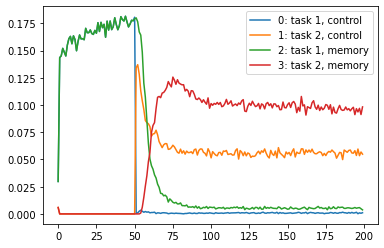

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/e64ced26a402acc09c1c2a6d1117ac6aadee09a3/regularizers-as-memory/spark-k8s-experiment-11-nlp.py
## EXECUTED WITH SPARK ON K8S: https://github.com/wdurno/spark-k8s/tree/v3.1.0

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-11.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 

plt.plot(scores0, label='0: task 1, control') ## control: task 1 accuracy, no memory applied  
plt.plot(scores1, label='1: task 2, control') ## control: task 2 accuracy, no memory applied 
plt.plot(scores2, label='2: task 1, memory') ## experimental: task 1 accuracy, memory applied  
plt.plot(scores3, label='3: task 2, memory') ## experimental: task 2 accuracy, memory applied 
plt.legend() 
plt.show() 

### interpretation 

- The benefits of synergizing new data with memorized data are plainly clear, since the AMS roughly doubles task 2 accuracy. 
- Experimental task 1 accuracy (line 2) briefly resists catestrophic forgetting. This strongly contrasts against control task 1 accuracy (line 0), which cleanly demonstrates catestrophic forgetting. 
- Degredation between iterations 75 and 100 illustrate the importance of re-memorizing, locking-in new performance. 

## experiment 2: memory retention and online learning

In this experiment, we illustrate online learning (without an infinitely-growing stored dataset) via memory retention. 
We take our previous training dataset and break it into 10 continuous subsets, then fit 3 kinds of models.
- Model 0 is a control, only fitting to one subset at a time. The subsets are small, so overfit is induced. 
- Model 1 is a control fit to the current subset and all prior subsets, thus illustrating how models fit when they have access to all data collected so far. So, this approach corresponds to the "save & re-use all data" approach to online deep learning.
- Model 2 is the experimental case, only ever fit to one data subset at a time, but applying memorization at the end of each subset. 

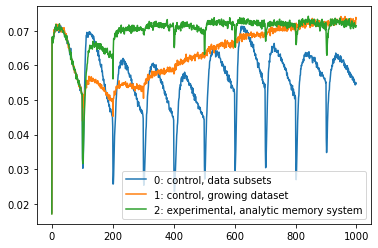

In [2]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/e64ced26a402acc09c1c2a6d1117ac6aadee09a3/regularizers-as-memory/spark-k8s-experiment-14-online-learning.py
## EXECUTED WITH SPARK ON K8S: https://github.com/wdurno/spark-k8s/tree/v3.1.0

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-14.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0: control, data subsets') ## control: fit to only a single data subset at a time, producing overfit 
plt.plot(scores1, label='1: control, growing dataset') ## control: fit to current and prior data subsets, simulating perfect memory 
plt.plot(scores2, label='2: experimental, analytic memory system') ## experimental: fit to current subset, but memorize all previous data subsets 
plt.legend() 
plt.show() 

### interpretation

- AMS resists overfit and retains previous observations. 
- AMS uses data _very efficiently_, reaching higher accuracies with less data, despite model 1 eventually reaching a similar accuracy. This is _super-efficient optimality_, and can also be observed in reinforcement learning in the appendix.

# OLD CONTENT, NEEDS RE-FORMATTING 

## experiment 1: Cartpole

We start with a _very_ simple example, proving-out concepts. 
The goal is to prove that $M$ provides a memory effect by detecting metric lift when the observation cache is cleared. 

For our first experiment, we run Cartpole for 1000 iterations, apply an experimental condition or 
control effect to the agent, then run for another 1000 iterations. Per condition, we track the cumulative score as our metric, 
resetting to zero upon game completions. The agent performs one optimizer update per iteration. 
Naturally, the metric has high-variance, so we use Databricks to execute 1000 experiments in parallel per condition, and average the metric.
Thus, the below-plotted metrics represent average score over time. 
The same agent is used up to the 1000 iterations before copying and applying effects, hence equivalent scores for the first half. 

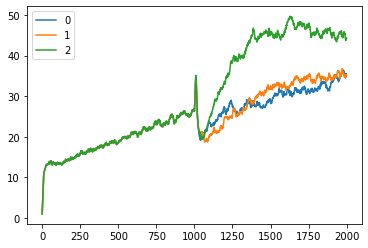

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-1-and-2.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-1-2.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition: use memory, discard observations at iteration 1000 
plt.legend() 
plt.show() 

### interpretation 

It is clear that the regularized memory term $M$ has provided significant metric lift. 
This in itself is obviously valuable and certainly still allows $M$ to apply a memory effect. 
However, a variety of concerns still stand.
- 1. Is this just the benefit of using a regularizer? Probably not, since we only have `[32, 32]` hidden nodes, but this must be tested.
- 2. 1000 iterations is very few. Does this have any benefit late-game? How about in more-complex games?
- 3. If we are observing memory, it is in the Fisher Information matrix, an asymptotic result representing no single observations but infinitely many. 
In what nuanced ways is this memory constrained? Is it similar to long-term memory, but not short-term? 
- 4. Exact Information matrices cannot be stored for large models due to their large $O(p^2)$ memory requirement. 
Can this method be made computationally feasible?

Prior to running this experiment, I expected the control to produce the highest scores at iteration 2000. 
I expect its lower performance is due to its observation cache being loaded with data generated by random play. 
It does make sense that it should out-perform condition 1 initially, but the poorer long-run performance was surprising.
This result illustrates the limited value of infinite memory. 

Immediately after iteration 1000, scores spike and fall together. 
I interpret this as a non-informative correlation, resulting from all agents starting new games simultaneously. 

## experiment 2: computational feasibility via low-rank approximations

The first concern we contend with is 4, computational feasibility. 
Usefully large models cannot use complete Fisher Information matrices, so we must experiment with approximations. 

We start by reducing the rank of the Information matrix by diagonalizing and only keeping the largest eigenvalues. 
Eigenvector and eigenvalue computation is still expensive, so this method will only prove feasibility without demonstrating a computational benefit. 

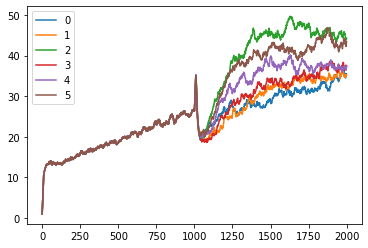

In [3]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-1-and-2.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

df = pd.read_csv('data/df-experiment-1-2.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 

plt.plot(scores0, label='0') ## control 0: use no memory, discard no observations 
plt.plot(scores1, label='1') ## control 1: use no memory, discard observations at iteration 1000 
plt.plot(scores2, label='2') ## experimental condition 1: use memory, discard observations at iteration 1000, use complete Hessian 
plt.plot(scores3, label='3') ## experimental condition 2: use memory, discard observations at iteration 1000, use 1 eigenvector to approximate the Hessian 
plt.plot(scores4, label='4') ## experimental condition 2: use memory, discard observations at iteration 1000, use 2 eigenvectors to approximate the Hessian 
plt.plot(scores5, label='5') ## experimental condition 2: use memory, discard observations at iteration 1000, use 10 eigenvectors to approximate the Hessian
plt.legend()
plt.show()

### interpretation 

We observe that it takes about 10 eigenvectors before lift is comparable to full-rank Fisher Information matrices. 
I'm not surprised to see that higher-ranked approximations provide better lift.
With evidence supporting the low-rank approach, it is time to test the effectiveness of a low-rank matrix approximation routine.

## experiment 3: computational feasibility

TODO I should actually cite work here 

For production models with $p$ parameters, $\mathcal{I}$ has $O(p^2)$ values, so cannot be stored. 
Nevertheless, we have good results with rank-reduced estimates, so will attempt to estimate $AA^T \approx \mathcal{I}$ for $A \in \mathbb{R}^{p \times r}$, 
where $r$ is significantly smaller than $p$. 
Most eigenpair algorithms are designed requiring all of $\mathcal{I}$ as input - we cannot do this, so have a challenge. 
Our only advantage is that we observe gradients $G_i \sim_{idd} N_p(0, \mathcal{I} )$. 

### estimating $\mathcal{I}$

Let us proceed by attempting estimation with the _Lanczos algorithm_, where we need not deal with $\mathcal{I}$, but only $\mathcal{I}v$. 
The Lanczos algorithm is a _Krylov_ method, built around _Krylov subspace_ $\text{span}\left\{ v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v \right\}$.

The key observation is this: we can calculate the _Krylov vectors_ $v, \mathcal{I}v, \mathcal{I}^2v, \ldots, \mathcal{I}^{r-1}v$ with computational 
efficiency when using estimate $ \hat{\mathcal{I}}  = n^{-1}\sum_i^n G_i G_i^T$. With $G_i$ and $v$ in $\mathbb{R}^{p \times 1}$, 
we can expand recursively as follows...

$$ \hat{\mathcal{I}}^m v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^T \right) v = \hat{\mathcal{I}}^{m-1} \left( \sum_i^n G_i G_i^Tv \right) $$

Notice how we now work with $O(nr)$ $O(p)$-time operations (totalling $O(nrp)$-time) and no $O(p^2)$-space operations. 
This is all possible because we only ever work with vector-vector operations, matrices are never used in forming the Krylov vectors. 
So, we should enjoy computational feasibility, if $nr$ is significantly smaller than $p^2$, which is expected in a deep learning context. 

### maintaining rank-reduction while combining rank-reduced estimates 

We may wish to re-memorize information, clearing an ever-growing observation cache as sampling continues. 
See experiment 8 for an example of this. 
Say we produce estimate $A_1 A_1^T$ at time step $t_1$ and $A_2 A_2^T$ at time step $t_2$. 
Notice that the naively combined estimate $A_1 A_1^T + A_2 A_2^T$ does not sustain its rank-reduced form, so violates our $O(p^2)$ space constraint. 
Fortunately, our Krylov estimation method can be slightly modified to maintain rank reduction. 

Calculate Krylov vectors $\{v, (A_1 A_1^T + A_2 A_2^T)v, (A_1 A_1^T + A_2 A_2^T)^2v, \ldots, (A_1 A_1^T + A_2 A_2^T)^{r-1}v \}$. 
Notice that, like above $(A_1 A_1^T + A_2 A_2^T)^{r-1}v = (A_1 A_1^T + A_2 A_2^T)^{r-2}(A_1 A_1^Tv + A_2 A_2^Tv)$, recursively. 
However, instead of vector-vector operations we have matrix-vector operations, but always with smaller $\mathbb{R}^{p \times r}$ matrices. 
So, each matrix-vector operation takes $O(rp)$ time, calculating all vectors takes $O(r^2p)$ time, and we observe our $O(p^2)$ space constraint. 

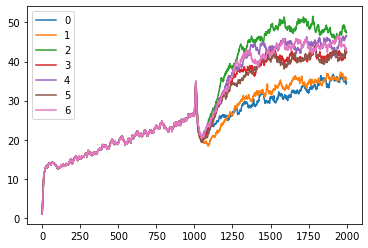

In [2]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/60aced4f32f049f1edcf4a1e497779d94cdef5b4/regularizers-as-memory/spark-k8s-experiment-3-comp-feasiblity.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-3.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 
scores6 = df.scores6.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control): No use of memory, do not discard data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data 
plt.plot(scores2, label='2') ## condition 2 (control): Use memory, do discard data 
plt.plot(scores3, label='3') ## condition 3 (control): Use memory, do discard data, use a rank-5 eigen-approximation 
plt.plot(scores4, label='4') ## condition 4 (control): Use memory, do discard data, use a rank-10 eigen-approximation 
plt.plot(scores5, label='5') ## condition 5 (experimental): Use memory, do discard data, use a rank-5 Krylov approximation 
plt.plot(scores6, label='6') ## condition 6 (experimental): Use memory, do discard data, use a rank-10 Kyrlov approximation 
plt.legend()
plt.show()

### interpretation

The Krylov method produce results comparable to eigenvector rank reduction, but in $O(nrp)$ time - very powerful.
Further, the $O(p^2)$-space $\mathcal{I}$ need never be stored in memory, only the $O(rp)$-space rank-reduced estimate. 

## experiment 4: comparison with L2 regularization

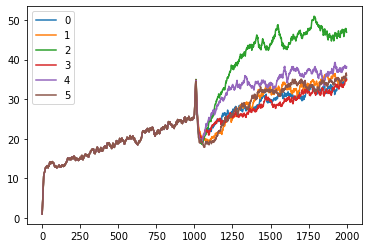

In [2]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-4-l2-regularizer.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

df = pd.read_csv('data/df-experiment-4.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 

plt.plot(scores0, label='0') ## No use of memory, no discarding of data 
plt.plot(scores1, label='1') ## No use of memory, do discard data 
plt.plot(scores2, label='2') ## Use memory, do discard data 
plt.plot(scores3, label='3') ## No use of memory, do not discard data, use L2 Regularizer = 1
plt.plot(scores4, label='4') ## No use of memory, do not discard data, use L2 Regularizer = 100
plt.plot(scores5, label='5') ## No use of memory, do discard data, use L2 Regularizer = 1 
plt.legend()
plt.show()

### interpretation 

TODO
- L2 under-performs but does add lift
- argue $M$ is actually an _optimal_ regularizer

## experiment 5: long games and convergence bahavior

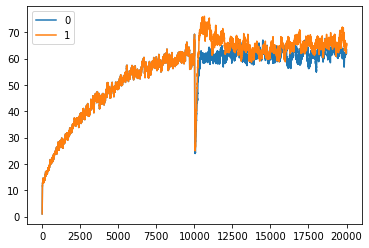

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: ## https://github.com/wdurno/notebooks/blob/7dd506614aa8e4a506a19bc4179308136047005b/regularizers-as-memory/spark-k8s-experiment-5-long-games.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-5.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data
plt.plot(scores1, label='1') ## condition 1 (experimental): Use memory, discard data
plt.legend()
plt.show()

#### interpretation

- At optimal play, memory confers less benefit.

## experiment 6: optimal $\lambda$

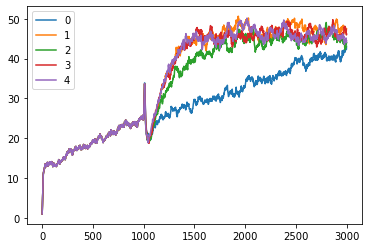

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: ## https://github.com/wdurno/notebooks/blob/cd2f4a3d3fcb54f5a3ec834550889e717891cedd/regularizers-as-memory/spark-k8s-experiment-6-optimal-lambda.py 
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-6.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data
plt.plot(scores1, label='1') ## condition 1 (control): Use memory, clear data, lambda = 1
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, clear data, optimal lambda = n1/n2
plt.plot(scores3, label='3') ## condition 3 (experimental): Use memory, clear data, lambda = n1/(n1+n2)
plt.plot(scores4, label='4') ## condition 4 (experimental): Use memory, clear data, near-optimal lambda = min(1, n1/n2)
plt.legend()
plt.show()

### interpretation

- Optimal $\lambda$ performed produced less lift, perhaps due to over-parameterization. 
- Near-optimal $\lambda$ with numerical stabilizer performed better. 

## experiment 7: overcoming forgetting 

Demonstrating transfer learning is equivalent to overcoming catastrophic forgetting. 
Reinforcement learning games' sample space changes with gameplay, so are almost stationary. 
Therefore, any forgetting in RL is a poor illustration of catarophic forgetting. 
However, some forgetting should be possible. 

In this experiment, we test regularization-as-memory's ability to overcome this forgetting. 
We do so by re-running experiment 1, but with 10 times more samples, thereby increasing statistical power. 

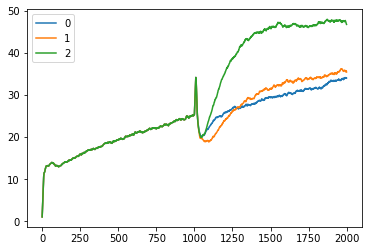

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/0add09936dd1261b79f19e6f3d0dd3c70b929f57/regularizers-as-memory/spark-k8s-experiment-7-forgetting.py 
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-7.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), without application of memory and without discarding data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data 
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data  
plt.legend() 
plt.show() 

### interpretation 

- This is about the best result we could've hoped for. 
Condition 1 (no memory, data discarded) visibly drops below the control (condition 0). 
This illustrates forgetting. 
- It is interesting that condition 1 eventually out-performs condition 0. 
I expect this is due to 
  - the agent having to first re-make mistakes, 
  - but then eventually having an observation queue with overall-more-important data. 
- The analytic storage mechanism employed by regularization-as-memory (condition 2) out-performs other conditions impressively. 
I expect the benefit comes from
  - mistakes not having to be remade, 
  - and the standard dimensional-reduction benefits of a regularizer. 

Combining the observations of (1) forgetting indeed occurring, and (2) regularization-as-memory overcoming forgetting 
suggests it's time to scale-this-up to a more-important transfer learning context. 
Instead of transfer learning within a game, we should test transfer learning between similar games. 
If successful, no-stronger a result should be expected due to our foundational _almost-stationary_ assumption. 
Instead, the burden will fall upon AI developers to construct continuity in transfer learning contexts. 

## experiment 8: relearning

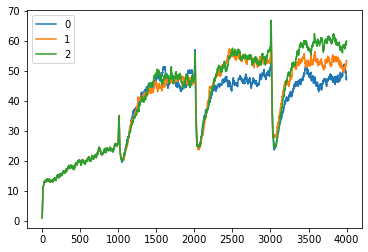

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/b3d82fad78355d5c8013d160a28018510f557bd1/regularizers-as-memory/spark-k8s-experiment-8-relearning.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-8.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control) Use memory, do discard data, memorize once
plt.plot(scores1, label='1') ## condition 1 (experimental): Use memory, do dicard data, memorize twice
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data, memorize thrice
plt.legend() 
plt.show() 

### interpretation 

Re-applying learning confers a significant benefit. 
I'll consider continuous learning first. 

## experiment 9: transfer learning

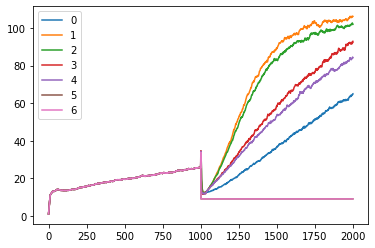

In [3]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: https://github.com/wdurno/notebooks/blob/0e34f740fb922ebb2ec3a905c2874863befca8ae/regularizers-as-memory/spark-k8s-experiment-9-transfer-learning.py
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s 

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-9.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 
scores3 = df.scores3.tolist() 
scores4 = df.scores4.tolist() 
scores5 = df.scores5.tolist() 
scores6 = df.scores6.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control), no memory, keep data, game modifier of 2
plt.plot(scores1, label='1') ## condition 1 (control): No memory, do discard data, game modifier of 2
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data, game modifier of 2
plt.plot(scores3, label='3') ## condition 3 (control): No use of memory, do discard data, game modifier of 4 
plt.plot(scores4, label='4') ## condition 4 (experimental): Use memory, do discard data, game modifier of 4  
plt.plot(scores5, label='5') ## condition 5 (control): No use of memory, do discard data, game modifier of 8  
plt.plot(scores6, label='6') ## condition 6 (experimental): Use memory, do discard data, game modifier of 8 
plt.legend() 
plt.show() 

### interpretation

This game is too simple. I need a transfer learning problem which can actually benefit from storing old data.

## experiment 10: LSTM + CNN

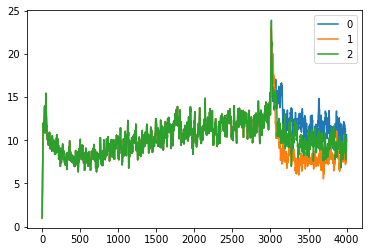

In [1]:
## DATA GENERATED WITH THIS CODE ON SPARK-K8S: TODO
## I FELT TOO CHEAP FOR DATABRICKS, SO I WROTE MY OWN: https://github.com/wdurno/spark-k8s 

import pandas as pd 
import matplotlib.pyplot as plt 

df = pd.read_csv('data/df-experiment-9.zip') 
scores0 = df.scores0.tolist() 
scores1 = df.scores1.tolist() 
scores2 = df.scores2.tolist() 

plt.plot(scores0, label='0') ## condition 0 (control): No use of memory, no discarding of data 
plt.plot(scores1, label='1') ## condition 1 (control): No use of memory, do discard data  
plt.plot(scores2, label='2') ## condition 2 (experimental): Use memory, do discard data  
plt.legend() 
plt.show() 

### interpretation

We have a negative result.
Given that
- this code is new, 
- and results have been good thus far, 

I expect there is a software bug.

## appendix: RL-reweighted (RLR) estimates 

This first estimate is designed to improve efficiency of sampling in reinforcement learning (RL) by 
up-weighting more-important observations. We'll use this estimate:

$$ \hat \theta_{RLR} = \hat \theta_{n_1+n_2} = \text{arg max}_\theta \left( \sum_{i=1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \right)^{-1} \left( \sum_{i=n_1+1}^{n_1+n_2} \| \hat r_i \|_2^{2b} \log f_X(X_i; \theta) - \sum_{i=1}^{n_1} \frac{\lambda}{2} (\theta - \hat \theta_{n_1+n_2-1})^T H_i (\theta - \hat \theta_{n_1+n_2-1}) \right) $$

where 
- $n_1$ is the number of priviously observed sameples, 
- $n_2$ is the number of newly observed samples, 
- $\hat r_i$ is the estimated reward for observation $i$, 
- $b > 0$ is a bias term,  
- $H_i = \| \hat r_i \|^{2b}_2 \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right) \left( \nabla_\theta \log f_X(X_j; \theta)|_{\theta = \hat \theta_{j-1}} \right)^T$ is a Hessian approximation, and
- $\hat \theta_0$ is an initial estimate guess, commonly required in optimization routines. 

Define $ M:= \sum_{i=1}^{n_1}(\theta - \theta_{n_1+n_2-1})^TH_i(\theta - \theta_{n_1+n_2-1})$, which we'll refer to as the "memory term". 
The key heuristic is that $M$, a quadratic regularizer, approximates large-sample likelihoods under maximization. 
This insight can be seen through a Taylor approximation near true $\theta$, designated $\theta_T$.

$\hat \theta_{MLE} = \text{arg max}_\theta n^{-1} \sum_{i=1}^n \log f_X(X_i;\theta) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + n^{-1}\sum_i (\theta - \theta_T)^T \nabla_\theta \log f_X(X_i; \theta_T) + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}\sum_i \log f_X(X_i; \theta_T) + 0 + n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

$ \approx \text{arg max}_\theta n^{-1}2^{-1} \sum_i (\theta - \theta_T)^T (\nabla_\theta^2 \log f_X(X_i; \theta_T))(\theta - \theta_T) $

This work basically tests the quality of our $M \approx \sum_i (\theta - \theta_T)^T (\nabla_\theta)^2 \log f_X(X_i; \theta_T)(\theta - \theta_T) $ heuristic.
If true, then we should see that the quadratic regularizer, $M$, affects memory through geometric constraints on the estimator.

Later, we'll experiment with recency bias and rank reductions for $M$.

Notice that $\hat \theta_{RLR}$ is asymptotically equivalent to a redistributed sampling, 
with more observations when they are more important. 
Hence, the essence of this computational efficiency strategy is to 
- add frequency bias to important observations, 
- and preserve their information via geometric estimator constraints.

## scratch space

In [2]:
## build MNIST data 

from tqdm import tqdm 
from torchvision import datasets, transforms 
from torch.utils.data import Dataset 

import matplotlib.pyplot as plt 
import random 

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) 
    ]) 

dataset1 = datasets.MNIST('../../data', train=True, download=True, transform=transform) 
dataset2 = datasets.MNIST('../../data', train=False, transform=transform) 

def subset_dataset(dataset, n, drop_labels=[]): 
    out = [] 
    for _ in range(n): 
        idx = random.randint(0, len(dataset)-1) 
        image, label = dataset[idx] 
        while label in drop_labels: 
            idx = random.randint(0, len(dataset)-1)  
            image, label = dataset[idx] 
            pass 
        out.append((image, label)) 
    return out 

dataset1_0_to_4_n1000 = subset_dataset(dataset1, n=1000, drop_labels=[5,6,7,8,9]) 
dataset1_5_to_9_n1000 = subset_dataset(dataset1, n=1000, drop_labels=[0,1,2,3,4]) 
dataset1_5_to_9_n30 = subset_dataset(dataset1, n=60, drop_labels=[0,1,2,3,4]) 
dataset1_5_to_9_n30_1 = subset_dataset(dataset1, n=60, drop_labels=[0,1,2,3,4]) 

dataset2_0_to_4_n1000 = subset_dataset(dataset2, n=1000, drop_labels=[5,6,7,8,9]) 
dataset2_5_to_9_n1000 = subset_dataset(dataset2, n=1000, drop_labels=[0,1,2,3,4]) 

class BiasedDataset(Dataset):
    'sample from 5 to 9 with probability `p`'
    def __init__(self,
            p=.5
            ):
        self.p = p 
        pass  
    def __len__(self):
        return 1000 
    def __getitem__(self, idx): 
        d = dataset1_0_to_4_n1000
        if bool(torch.rand([]) < self.p):
            d = dataset1_5_to_9_n1000
            pass 
        image, label = d[idx] 
        return image, label 
    pass 

In [3]:
## build NLP data 

import torch 
import pickle 
from collections import Counter 

## You'll need to uncomment this before running `build_nlp_data` 
#!pip install nltk

def build_nlp_data():
    import nltk
    nltk.download('punkt')
    import requests 
    from nltk.tokenize import word_tokenize
    shakespeare = requests.get('https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt').text 
    tokens = word_tokenize(shakespeare) 
    unique_tokens = list(set(tokens)) 
    map = dict(zip(unique_tokens, list(range(len(unique_tokens))))) 
    tokens_as_ints = [] 
    for token in tokens:
        tokens_as_ints.append(map[token]) 
        pass 
    with open('shakespeare_tokens.pkl', 'wb') as f: 
        pickle.dump(tokens_as_ints, f)
        pass 
    pass 

RARE_TOKEN_CUTOFF = 10 
MAX_TOKENS = 100 

def load_shakes_tokens(): 
    with open('shakespeare_tokens.pkl', 'rb') as f: 
        shakes_tokens = pickle.load(f) 
        pass 
    ## map rare values to zero, then re-index tokens 
    shakes_tokens = [t+1 for t in shakes_tokens] ## reserve 0 for rare tokens 
    token_to_count_map = dict(Counter(shakes_tokens)) 
    idx = 1
    for token, count in token_to_count_map.items():
        if count < RARE_TOKEN_CUTOFF: 
            token_to_count_map[token] = 0 ## repurpose `count` to `new_index`
        else: 
            token_to_count_map[token] = idx 
            idx += 1 
            pass 
        pass 
    shakes_tokens = [token_to_count_map[token] for token in shakes_tokens] 
    ## reduce number of tokens 
    shakes_tokens = [ token % MAX_TOKENS for token in shakes_tokens] 
    return shakes_tokens 

#build_nlp_data() 
shakes_tokens = load_shakes_tokens() 
N_SHAKES_OUT = len(set(shakes_tokens)) 
print(f'Number of unique tokens: {N_SHAKES_OUT}') 
SHAKES_SERIES_LEN = 20 
N_TRANSFER_LEARNING_SIZE = 10 

class NLPDataset(Dataset):
    'converts a sequence of token indices into a dataset'
    def __init__(self, 
            token_list, 
            sample_length=10 
            ): 
        ## store content 
        self.token_list = torch.tensor(token_list) 
        self.sample_length = sample_length 
        self.n = len(token_list) - sample_length - 1 ## -1 for final token to be used as a label 
        pass  
    def __len__(self): 
        return self.n 
    def __getitem__(self, idx): 
        x = self.token_list[idx:(idx+self.sample_length)] 
        y = self.token_list[idx + self.sample_length] 
        return x, y 
    pass 

class EvenOrOddNLPDataset(Dataset):
    'subsamples an NLPDataset to either even or odd values'
    def __init__(self, nlp_dataset, even=True, random_subset_size=None): 
        self.nlp_dataset = nlp_dataset 
        self.even = even 
        even_odd_filter = None 
        def even_odd_filter(value):
            if even:
                if value % 2 == 0: 
                    return True 
            else: ## odd 
                if value % 2 == 1:
                    return True 
                pass 
            return False 
        if random_subset_size is None: 
            self.indices = [idx for idx in range(len(nlp_dataset)) if even_odd_filter(int(nlp_dataset[idx][1]))] 
        else:
            ## subset the data randomly 
            self.indices = [] 
            for _ in range(random_subset_size): 
                continue_loop = True 
                while continue_loop: 
                    idx = random.randint(0, len(nlp_dataset)-1) 
                    if even_odd_filter(int(nlp_dataset[idx][1])): 
                        ## found! add to indices 
                        self.indices.append(idx) 
                        ## stop looking 
                        continue_loop = False 
                        pass 
                    pass 
                pass 
            pass
        self.n = len(self.indices) 
        pass 
    def __len__(self): 
        return self.n 
    def __getitem__(self, idx): 
        idx = self.indices[idx]  
        return self.nlp_dataset[idx] 
    pass 

nlp_train = NLPDataset(shakes_tokens[:700000], sample_length=SHAKES_SERIES_LEN) 
nlp_test = NLPDataset(shakes_tokens[700000:], sample_length=SHAKES_SERIES_LEN) 

nlp_even_train = EvenOrOddNLPDataset(nlp_train, even=True, random_subset_size=N_TRANSFER_LEARNING_SIZE) ## subset demonstrates transfer learning 
nlp_odd_train = EvenOrOddNLPDataset(nlp_train, even=False) 
nlp_even_test = EvenOrOddNLPDataset(nlp_test, even=True) 
nlp_odd_test = EvenOrOddNLPDataset(nlp_test, even=False) 

print(f'len(nlp_even_train): {len(nlp_even_train)}, counts: {dict(Counter([int(nlp_even_train[idx][1]) for idx in range(len(nlp_even_train))]))}') 
print(f'len(nlp_odd_train): {len(nlp_odd_train)}, counts: {dict(Counter([int(nlp_odd_train[idx][1]) for idx in range(len(nlp_odd_train))]))}')
print(f'len(nlp_even_test): {len(nlp_even_test)}, counts: {dict(Counter([int(nlp_even_test[idx][1]) for idx in range(len(nlp_even_test))]))}')
print(f'len(nlp_odd_test): {len(nlp_odd_test)}, counts: {dict(Counter([int(nlp_odd_test[idx][1]) for idx in range(len(nlp_odd_test))]))}') 

Number of unique tokens: 100
len(nlp_even_train): 10, counts: {66: 2, 24: 2, 20: 1, 0: 3, 68: 1, 58: 1}
len(nlp_odd_train): 386051, counts: {9: 54150, 13: 3922, 15: 12326, 3: 18298, 17: 51591, 7: 3131, 19: 16044, 21: 3794, 11: 10185, 23: 15641, 1: 11337, 25: 3627, 27: 9812, 29: 3932, 31: 4167, 33: 5772, 35: 3805, 37: 5447, 39: 4135, 41: 3804, 43: 10005, 45: 6115, 47: 3878, 49: 3232, 51: 6325, 53: 13373, 55: 3557, 57: 2869, 59: 3296, 61: 11960, 63: 4000, 65: 3233, 67: 2363, 69: 5818, 71: 2878, 73: 2539, 75: 3795, 77: 3122, 79: 2178, 81: 2604, 83: 2138, 85: 5085, 87: 4628, 89: 1590, 91: 3427, 93: 6975, 95: 5664, 97: 8357, 99: 2631, 5: 3496}
len(nlp_even_test): 191377, counts: {50: 3419, 88: 1774, 56: 8053, 32: 2421, 24: 2723, 74: 7586, 20: 3743, 2: 5838, 34: 3210, 96: 3306, 54: 2124, 12: 4621, 0: 25456, 70: 11425, 10: 9994, 18: 6757, 30: 3115, 4: 3404, 22: 5766, 62: 3085, 98: 4477, 14: 2195, 58: 3176, 46: 3727, 94: 7804, 6: 2611, 86: 1491, 80: 1760, 90: 2643, 68: 2183, 66: 1387, 72: 1799

In [4]:
## define model 

import torch 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 

from lanczos import l_lanczos 

N_OUT = 10 
LEARNING_RATE = 0.001 
BATCH_SIZE = 100
TRAINING_ITERS = 1000 
MEMORIZATION_SIZE = 1000 

class Model(nn.Module): 
    def __init__(self, 
            losses=None, 
            accs_low=None,
            accs_high=None, 
            regs=None, 
            net_type='dense', 
            batch_norm=True, 
            hessian_sum=None,
            hessian_sum_low_rank_half = None, 
            hessian_denominator=None, 
            hessian_center=None, 
            log1p_reg=False): 
        super(Model, self).__init__() 
        ## init params 
        if net_type == 'dense': 
            self.fc1 = nn.Linear(28*28, 8) 
            if batch_norm:
                self.fc1_bn = nn.BatchNorm1d(8) 
            self.relu1 = nn.ReLU() 
            self.fc2 = nn.Linear(8, 16)  
            if batch_norm:
                self.fc2_bn = nn.BatchNorm1d(16) 
            self.relu2 = nn.ReLU() 
            self.fc3 = nn.Linear(16, N_OUT) 
            self.sigmoid = nn.Sigmoid() 
        elif net_type == 'dense_1': 
            self.fc1 = nn.Linear(28*28, 32) 
            if batch_norm:
                self.fc1_bn = nn.BatchNorm1d(32) 
            self.relu1 = nn.ReLU() 
            self.fc2 = nn.Linear(32, 64)  
            if batch_norm:
                self.fc2_bn = nn.BatchNorm1d(64) 
            self.relu2 = nn.ReLU() 
            self.fc3 = nn.Linear(64, N_OUT) 
            self.sigmoid = nn.Sigmoid() 
        elif net_type == 'cnn': 
            self.conv1 = nn.Conv2d(1, 8, kernel_size=6, stride=4) 
            if batch_norm: 
                self.conv1_bn = nn.BatchNorm2d(8) 
            self.relu1 = nn.ReLU() 
            self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=2) 
            if batch_norm: 
                self.conv2_bn = nn.BatchNorm2d(32) 
            self.relu2 = nn.ReLU() 
            self.fc1 = nn.Linear(16*2*2, 16) 
            if batch_norm: 
                self.fc1_bn = nn.BatchNorm1d(16) 
            self.relu3 = nn.ReLU() 
            self.fc2 = nn.Linear(16, N_OUT) 
        elif net_type == 'nlp': 
            self.embedding = nn.Embedding(N_SHAKES_OUT, embedding_dim=32) 
            self.conv1 = nn.Conv1d(32, 64, kernel_size=5, stride=3) 
            if batch_norm: 
                self.conv1_bn = nn.BatchNorm1d(64) 
            self.relu1 = nn.ReLU() 
            self.conv2 = nn.Conv1d(64, 128, kernel_size=3, stride=2) 
            if batch_norm: 
                self.conv2_bn = nn.BatchNorm1d(128) 
            self.relu2 = nn.ReLU() 
            self.fc1 = nn.Linear(128*2, 128) 
            if batch_norm: 
                self.fc1_bn = nn.BatchNorm1d(128) 
            self.relu3 = nn.ReLU() 
            self.fc2 = nn.Linear(128, N_SHAKES_OUT) 
            self.softmax = nn.Softmax(dim=1) 
            pass 
        ## data structures 
        self.hessian_sum = hessian_sum 
        self.hessian_sum_low_rank_half = hessian_sum_low_rank_half 
        self.hessian_denominator = hessian_denominator 
        self.hessian_center = hessian_center 
        if losses is None:
            self.losses = [] 
        else: 
            self.losses = losses 
            pass 
        if accs_low  is None:
            self.accs_low = [] 
        else: 
            self.accs_low = accs_low 
            pass 
        if accs_high  is None: 
            self.accs_high = [] 
        else: 
            self.accs_high = accs_high 
            pass 
        if regs  is None: 
            self.regs = [] 
        else: 
            self.regs = regs 
            pass 
        self.net_type = net_type
        self.batch_norm = batch_norm 
        self.log1p_reg = log1p_reg
        ## optimizer 
        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE) 
        pass 
    def forward(self, x): 
        if self.net_type in ['dense', 'dense_1']: 
            x = self.fc1(x) 
            if self.batch_norm: 
                x = self.fc1_bn(x) 
            x = self.relu1(x) 
            x = self.fc2(x) 
            if self.batch_norm: 
                x = self.fc2_bn(x) 
            x = self.relu2(x) 
            x = self.fc3(x) 
            x = self.sigmoid(x) 
        elif self.net_type == 'cnn': 
            x = self.conv1(x) 
            if self.batch_norm: 
                x = self.conv1_bn(x) 
            x = self.relu1(x) 
            x = self.conv2(x) 
            if self.batch_norm: 
                x = self.conv2_bn(x) 
            x = self.relu2(x) 
            x = x.flatten(start_dim=1) 
            x = self.fc1(x) 
            if self.batch_norm: 
                x = self.fc1_bn(x) 
            x = self.relu3(x) 
            x = self.fc2(x) 
        elif self.net_type == 'nlp': 
            x = self.embedding(x) 
            x = x.permute((0, 2, 1)) 
            x = self.conv1(x) 
            if self.batch_norm: 
                x = self.conv1_bn(x) 
            x = self.relu1(x) 
            x = self.conv2(x) 
            if self.batch_norm: 
                x = self.conv2_bn(x) 
            x = self.relu2(x) 
            x = x.flatten(start_dim=1) 
            x = self.fc1(x) 
            if self.batch_norm: 
                x = self.fc1_bn(x) 
            x = self.relu3(x) 
            x = self.fc2(x) 
            x = self.softmax(x) 
            pass 
        return x 
    def copy(self): 
        out = Model( 
            losses=self.losses.copy(), 
            accs_low=self.accs_low.copy(), 
            accs_high=self.accs_high.copy(), 
            regs=self.regs.copy(), 
            net_type=self.net_type, 
            batch_norm=self.batch_norm, 
            hessian_sum=self.hessian_sum.detach().clone() if self.hessian_sum is not None else None, 
            hessian_sum_low_rank_half=self.hessian_sum_low_rank_half.detach().clone() if self.hessian_sum_low_rank_half is not None else None, 
            hessian_denominator=self.hessian_denominator, 
            hessian_center=self.hessian_center.detach().clone() if self.hessian_center is not None else None, 
            log1p_reg=self.log1p_reg 
        ) 
        out.load_state_dict(self.state_dict()) 
        return out 
    def fit(self, training_dataset, n_iters=TRAINING_ITERS, ams=False, drop_labels=[], 
            random_label_probability=0., silence_tqdm=False, acc_frequency=1, halt_acc=None): 
        ''' 
        fit the model 
        inputs: 
        - n_iters: how many optimizer iterations to run 
        - ams: use analytic memory system? if yes, set to lambda value 
        - drop_labels: omit these labels from training 
        - random_label_probability: probability of randomly selecting a label, instead of using the correct one 
        side-effects: 
        - model parameter updates 
        ''' 
        pbar = tqdm(range(n_iters), disable=silence_tqdm) 
        for pbar_idx in pbar: 
            self.train() 
            self.zero_grad() 
            x, y = self.__get_batch(training_dataset, drop_labels=drop_labels, random_label_probability=random_label_probability) 
            loss = self.__get_loss(x, y) 
            if ams: 
                reg = self.__get_regularizer() 
                loss += ams * reg ## "+" because optimizer minimizes 
                self.regs.append(float(ams * reg)) 
            else: 
                self.regs.append(0.) 
                pass 
            loss_f = float(loss) 
            self.losses.append(loss_f) 
            loss.backward() 
            self.optimizer.step() 
            if pbar_idx % acc_frequency == 0: 
                if self.net_type in ['dense', 'dense_1', 'cnn']: 
                    self.accs_low.append(self.acc(dataset2_0_to_4_n1000)) 
                    self.accs_high.append(self.acc(dataset2_5_to_9_n1000)) 
                elif self.net_type in ['nlp']: 
                    self.accs_low.append(self.acc(nlp_odd_test, batch_size=1000)) ## TODO small batch size for testing purposes 
                    high_acc = self.acc(nlp_even_test, batch_size=1000) 
                    self.accs_high.append(high_acc) 
                    if halt_acc is not None: 
                        if high_acc > halt_acc: 
                            self.hessian_center = self.get_parameter_vector().detach() 
                            halt_acc = high_acc
                        pass 
                    pass  
                pass 
            pbar.set_description(f'loss: {loss_f}') 
            pass 
        pass 
    def memorize(self, dataset, drop_labels=[], memorization_size=MEMORIZATION_SIZE, 
            random_label_probability=0., silence_tqdm=False, krylov_rank=0, krylov_eps=0.): 
        self.eval() 
        if self.hessian_denominator is None: 
            self.hessian_denominator = 0. 
            pass 
        self.hessian_center = self.get_parameter_vector().detach() 
        get_grad_generator = self.__get_get_grad_generator(dataset, n_grads=memorization_size, drop_labels=drop_labels, random_label_probability=random_label_probability) 
        if krylov_rank < 1: 
            ## use full-rank Information Matrix estimate 
            if self.hessian_sum is None: 
                self.hessian_sum = 0. 
            grad_generator = get_grad_generator() 
            pbar = tqdm(grad_generator(), disable=silence_tqdm) 
            for grad in pbar: 
                self.hessian_sum += (grad.matmul(grad.transpose(1, 0))).detach() 
                self.hessian_denominator += 1 
                pass 
        else: 
            ## use Krylov method 
            p = int(self.get_parameter_vector().shape[0])  
            self.hessian_denominator += memorization_size 
            self.hessian_sum_low_rank_half = l_lanczos(get_grad_generator, r=krylov_rank, p=p, eps=krylov_eps) 
            pass 
        pass 
    def acc(self, dataset, batch_size=1000, drop_labels=[]): 
        self.eval() 
        x, y = self.__get_batch(dataset, batch_size=batch_size, drop_labels=drop_labels) 
        y_hat = self.forward(x) 
        acc = (y.argmax(dim=1) == y_hat.argmax(dim=1)).float().mean() 
        acc_f = float(acc) 
        return acc_f 
    def get_parameter_vector(self): 
        return torch.cat([p.reshape([-1, 1]) for p in self.parameters()]) 
    def save(self, path): 
        torch.save(self.state_dict(), path) 
        pass 
    def load(self, path): 
        self.load_state_dict(torch.load(path)) 
        pass 
    def __get_get_grad_generator(self, dataset, n_grads, **argv):
        def get_grad_generator(): 
            def grad_generator(): 
                for _ in range(n_grads): 
                    self.zero_grad() 
                    x, y = self.__get_batch(dataset, batch_size=1, **argv) 
                    loss = self.__get_loss(x, y) 
                    loss.backward() 
                    grad = torch.cat([p.grad.reshape([-1, 1]) for p in self.parameters()]) 
                    yield grad 
                pass 
            return grad_generator() 
        return get_grad_generator 
    def __get_loss(self, x, y): 
        y_hat = self.forward(x) 
        loss = F.smooth_l1_loss(y_hat, y) 
        return loss 
    def __get_regularizer(self): 
        if self.hessian_sum is None and self.hessian_sum_low_rank_half is None: 
            return 0. 
        p = self.get_parameter_vector() 
        p0 = self.hessian_center 
        if self.hessian_sum_low_rank_half is None: 
            hess = self.hessian_sum / self.hessian_denominator 
            reg = (p - p0).transpose(1, 0).matmul(hess).matmul(p - p0).reshape([]) 
        else: 
            hess_half = (self.hessian_sum_low_rank_half / self.hessian_denominator).detach()  
            reg = (p - p0).transpose(1, 0).matmul(hess_half).matmul(hess_half.transpose(1, 0)).matmul(p - p0).reshape([])
            pass 
        if self.log1p_reg: 
            reg = torch.log1p(reg) 
        return reg 
    def __get_batch(self, dataset, batch_size=BATCH_SIZE, **argv): 
        if self.net_type in ['dense', 'dense_1', 'cnn']: 
            return self.__get_mnist_batch(dataset, batch_size=batch_size, **argv) 
        elif self.net_type in ['nlp']: 
            return self.__get_nlp_batch(dataset, batch_size=batch_size, **argv) 
        pass 
    def __get_nlp_batch(self, dataset, batch_size=BATCH_SIZE, random_label_probability=0., drop_labels=[]): 
        x_list = [] 
        y_list = [] 
        for _ in range(batch_size): 
            idx = random.randint(0, len(dataset)-1) 
            x, y = dataset[idx] 
            #y = torch.tensor([1. if int(y) == idx else 0. for idx in range(N_SHAKES_OUT)]) ## one-hot representation 
            if random_label_probability > 0.: 
                if bool(torch.rand([]) < random_label_probability): 
                    y = torch.tensor(random.randint(0, N_SHAKES_OUT-1)) 
                    pass 
                pass 
            y = nn.functional.one_hot(y, num_classes=N_SHAKES_OUT).float() 
            x = x.reshape([1, -1]) 
            y = y.reshape([1, -1]) 
            x_list.append(x) 
            y_list.append(y) 
            pass 
        x = torch.cat(x_list, dim=0) 
        y = torch.cat(y_list, dim=0) 
        return x, y  
    def __get_mnist_batch(self, dataset, batch_size=BATCH_SIZE, drop_labels=[], random_label_probability=0.): 
        x_list = [] 
        y_list = [] 
        for _ in range(batch_size): 
            idx = random.randint(0, len(dataset)-1) 
            while dataset[idx][1] in drop_labels: 
                idx = random.randint(0, len(dataset)-1) 
            image, label = dataset[idx] 
            if random_label_probability > 0.: 
                if bool(torch.rand([]) < random_label_probability): 
                    label = random.randint(0, N_OUT-1) 
                    pass 
                pass 
            x, y = self.__build_decimal_datum(image, label)  
            x_list.append(x) 
            y_list.append(y) 
            pass 
        x = torch.cat(x_list, dim=0) 
        y = torch.cat(y_list, dim=0)  
        return x, y 
    def __build_decimal_datum(self, image, label): 
        'one-hot encode an image-label pair' 
        y = torch.tensor([1. if label == idx else 0. for idx in range(N_OUT)]) ## one-hot representation 
        ## reshape to column vectors 
        x = None 
        if self.net_type in ['dense', 'dense_1']: 
            x = image.reshape([1, -1]) 
        elif self.net_type == 'cnn': 
            x = image.unsqueeze(dim=0) 
            pass 
        y = y.reshape([1, -1]) 
        return x, y 
    pass 

control odd fit complete
experimental odd memorization complete
control even fit complete
experimental even fit complete


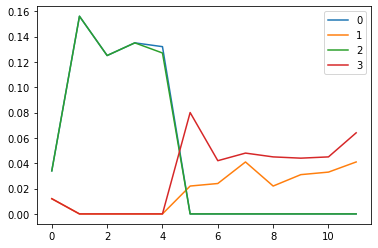

In [14]:
## NLP 

N_ITERS = 310 
LAMBDA = 1e-1 
ACC_FREQ=100
RANDOM_LABEL_PROBABILITY=.0

model = Model(net_type='nlp', batch_norm=False, log1p_reg=False) 
model.fit(nlp_odd_train, n_iters=N_ITERS, silence_tqdm=True, acc_frequency=ACC_FREQ, random_label_probability=RANDOM_LABEL_PROBABILITY) 
print('control odd fit complete') 

model = model.copy() 
ams_model = model.copy() 
ams_model.memorize(nlp_odd_train, memorization_size=N_ITERS, silence_tqdm=True, krylov_rank=10, krylov_eps=1e1) ## observation: LAMBDA*krylov_eps seems to be an important convergence statistic  
ams_model = ams_model.copy() 
print('experimental odd memorization complete') 

## apply a small dataset 
model.fit(nlp_even_train, n_iters=N_ITERS+400, silence_tqdm=True, acc_frequency=ACC_FREQ, random_label_probability=RANDOM_LABEL_PROBABILITY) 
print('control even fit complete') 
ams_model.fit(nlp_even_train, n_iters=N_ITERS+400, silence_tqdm=True, ams=LAMBDA, acc_frequency=ACC_FREQ, halt_acc=.0, random_label_probability=RANDOM_LABEL_PROBABILITY) ## TODO halt_acc fits to test dataset - fix this!!!
print('experimental even fit complete') 

plt.plot(model.accs_low, label='0') ## control: odd 
plt.plot(model.accs_high, label='1') ## control: even 
plt.plot(ams_model.accs_low, label='2') ## experimental: odd 
plt.plot(ams_model.accs_high, label='3') ## experimental: even 
plt.legend() 
plt.show() 

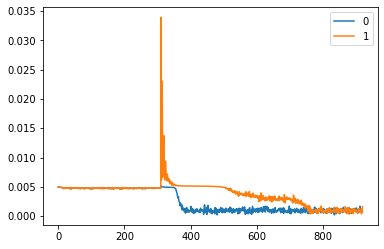

In [10]:
plt.plot(model.losses, label='0') 
plt.plot(ams_model.losses, label='1') 
plt.legend() 
plt.show() 

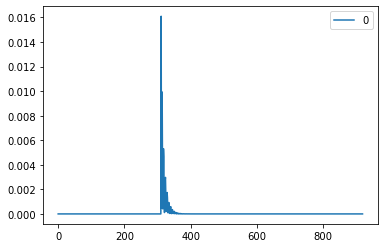

In [203]:
plt.plot(ams_model.regs, label='0') 
plt.legend() 
plt.show() 

In [204]:
ams_model.regs[-1]

5.641371701378683e-13

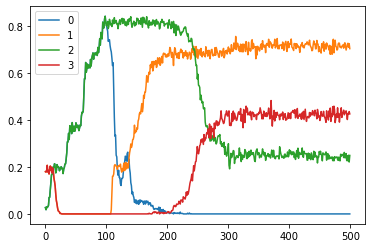

In [14]:
## Memory effect observed, but suffers a trade-off. 
## So, memorizing two distributions has not-yet resulted in a synergized model. 

model = Model(batch_norm=False, log1p_reg=True) 
model.fit(dataset1_0_to_4_n1000, n_iters=100, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(dataset1_0_to_4_n1000, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
## copies have effected performance -- apply effect equally 
ams_model = ams_model.copy() 
model = model.copy() 

N = 200 
LAMBDA = 5*1e4 
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

ams_model.memorize(dataset1_5_to_9_n30, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
ams_model = ams_model.copy() 
ams_model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True, ams=LAMBDA) ## some new data 
model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

### interpretation 

Analytic memory degrades metrics for new datasets, but it can indeed be used for retention successfully.
I expect this is because parameter-space is constrained to lower-dimensional solutions. 
So, the effective number of available parameters is reduced, resulting in powerful model. 
Note: it is thus worthwhile to explore how larger models behave, while all other parameters are fixed. 
It could simply be that memorizing different datasets always comes with a dimensional cost. 
Perhaps sampling distributions must be very similar before the synergize and benefit from shared dimensional space. 

Regardless of degredation, top accuracy isn't always the most-important. 
If memorization is indeed valuable, then this is a fair trade. 
Synergies between distributions should be expected to come for free. 

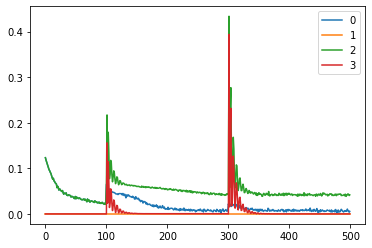

In [15]:
plt.plot(model.losses, label='0') 
plt.plot(model.regs, label='1') 
plt.plot(ams_model.losses, label='2') 
plt.plot(ams_model.regs, label='3') 
#plt.ylim([-.01, .1]) 
plt.legend() 
plt.show() 

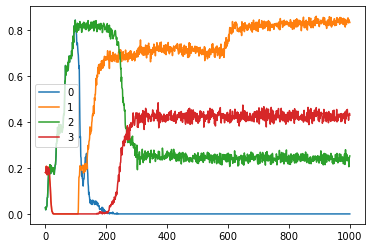

In [16]:
N = 500
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

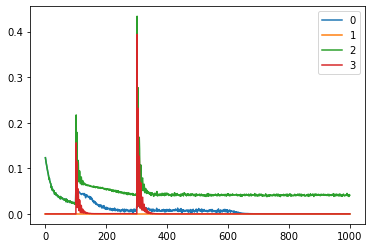

In [17]:
plt.plot(model.losses, label='0') 
plt.plot(model.regs, label='1') 
plt.plot(ams_model.losses, label='2') 
plt.plot(ams_model.regs, label='3') 
#plt.ylim([-.01, .1]) 
plt.legend() 
plt.show() 

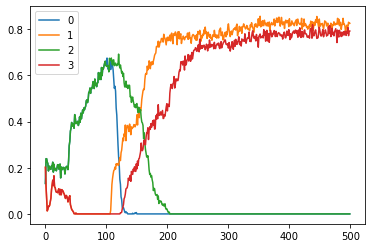

In [28]:
## try a biased training dataset 

biased_dataset = BiasedDataset(p=.2)

model = Model(batch_norm=False, log1p_reg=True) 
model.fit(biased_dataset, n_iters=100, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(biased_dataset, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
## copies have effected performance -- apply effect equally 
ams_model = ams_model.copy() 
model = model.copy() 

N = 200 
LAMBDA = 1e3  
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

#ams_model.memorize(dataset1_5_to_9_n30, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
#ams_model = ams_model.copy() 
ams_model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True, ams=LAMBDA) ## some new data 
model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

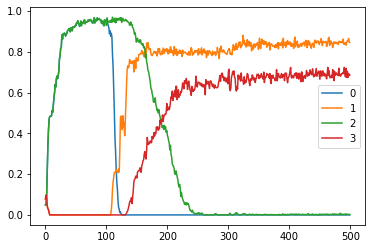

In [38]:
## try a bigger model 

model = Model(batch_norm=False, log1p_reg=True, net_type='dense_1') 
model.fit(dataset1_0_to_4_n1000, n_iters=100, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(dataset1_0_to_4_n1000, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
## copies have effected performance -- apply effect equally 
ams_model = ams_model.copy() 
model = model.copy() 

N = 200 
LAMBDA = 1e5 
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

ams_model.memorize(dataset1_5_to_9_n30, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
ams_model = ams_model.copy() 
ams_model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True, ams=LAMBDA) ## some new data 
model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

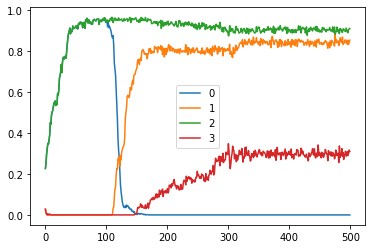

In [39]:
## try a bigger model, and bigger lambda 

model = Model(batch_norm=False, log1p_reg=True, net_type='dense_1') 
model.fit(dataset1_0_to_4_n1000, n_iters=100, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(dataset1_0_to_4_n1000, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
## copies have effected performance -- apply effect equally 
ams_model = ams_model.copy() 
model = model.copy() 

N = 200 
LAMBDA = 1e6 
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

ams_model.memorize(dataset1_5_to_9_n30, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
ams_model = ams_model.copy() 
ams_model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True, ams=LAMBDA) ## some new data 
model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

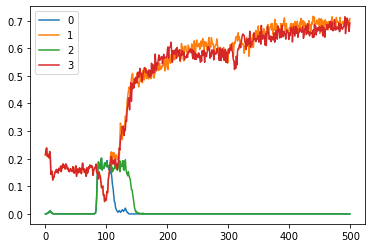

In [8]:
## trying mathematically-informed lambda n_1/n_2/2  

model = Model(batch_norm=False, log1p_reg=True) 
model.fit(dataset1_0_to_4_n1000, n_iters=100, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(dataset1_0_to_4_n1000, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
## copies have effected performance -- apply effect equally 
ams_model = ams_model.copy() 
model = model.copy() 

N = 200
LAMBDA = 1e2
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

ams_model.memorize(dataset1_5_to_9_n30, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
ams_model = ams_model.copy() 
ams_model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True, ams=LAMBDA) ## some new data 
model.fit(dataset1_5_to_9_n30_1, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

In [5]:
a = torch.tensor([[1,2],[3,4.]])
b = torch.tensor([[2,2],[2,2.]])
F.smooth_l1_loss(a,b) 

tensor(0.6250)

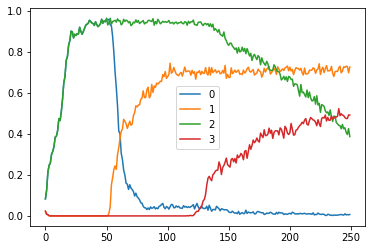

In [142]:
## attempting CNNs... basically the same result 

model = Model(net_type='cnn', batch_norm=False, log1p_reg=True) 
model.fit(dataset1_0_to_4_n1000, n_iters=50, silence_tqdm=True) 
ams_model = model.copy() 
ams_model.memorize(dataset1_0_to_4_n1000, memorization_size=2*BATCH_SIZE, silence_tqdm=True) 
ams_model = ams_model.copy() 

N = 200
LAMBDA = 1e5
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

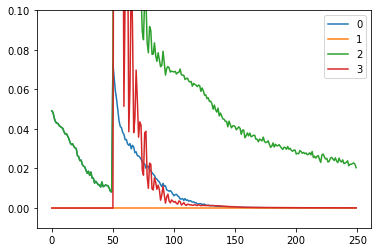

In [143]:
plt.plot(model.losses, label='0') 
plt.plot(model.regs, label='1') 
plt.plot(ams_model.losses, label='2') 
plt.plot(ams_model.regs, label='3') 
plt.ylim([-.01, .1]) 
plt.legend() 
plt.show() 

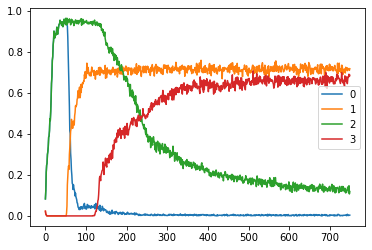

In [144]:
N = 500
ams_model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True, ams=LAMBDA) 
model.fit(dataset1_5_to_9_n30, n_iters=N, silence_tqdm=True) 

plt.plot(model.accs_low, label='0') 
plt.plot(model.accs_high, label='1') 
plt.plot(ams_model.accs_low, label='2') 
plt.plot(ams_model.accs_high, label='3') 
plt.legend() 
plt.show() 

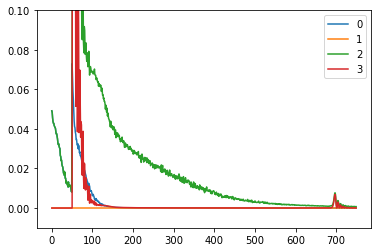

In [145]:
plt.plot(model.losses, label='0') 
plt.plot(model.regs, label='1') 
plt.plot(ams_model.losses, label='2') 
plt.plot(ams_model.regs, label='3') 
plt.ylim([-.01, .1]) 
plt.legend() 
plt.show() 

In [13]:
import pickle 
from collections import Counter 

## You'll need to uncomment this before running `build_nlp_data` 
#!pip install nltk

def build_nlp_data():
    import nltk
    nltk.download('punkt')
    import requests 
    from nltk.tokenize import word_tokenize
    shakespeare = requests.get('https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt').text 
    tokens = word_tokenize(shakespeare) 
    unique_tokens = list(set(tokens)) 
    map = dict(zip(unique_tokens, list(range(len(unique_tokens))))) 
    tokens_as_ints = [] 
    for token in tokens:
        tokens_as_ints.append(map[token]) 
        pass 
    with open('shakespeare_tokens.pkl', 'wb') as f: 
        pickle.dump(tokens_as_ints, f)
        pass 
    pass 

def load_shakes_tokens(): 
    with open('shakespeare_tokens.pkl', 'rb') as f: 
        shakes_tokens = pickle.load(f) 
        pass 
    return shakes_tokens 

#build_nlp_data() 
shakes_tokens = load_shakes_tokens() 

token_to_count_map = dict(Counter(shakes_tokens)) 
SHAKES_OUT_MAP = [token for token in token_to_count_map if token_to_count_map[token] > 100] 
N_SHAKES_OUT = len(SHAKES_OUT_MAP) 
SHAKES_SERIES_LEN = 20 

class NLPDataset(Dataset):
    'converts a sequence of token indices into a dataset'
    def __init__(self,
            token_list, 
            sample_length=10 
            ): 
        self.token_list = torch.tensor(token_list) 
        self.sample_length = sample_length 
        self.n = len(token_list) - sample_length 
        pass  
    def __len__(self): 
        return self.n 
    def __getitem__(self, idx): 
        return self.token_list[idx:(idx+self.sample_length)] 
    pass 

nlp_train = NLPDataset(shakes_tokens[:7000000], sample_length=SHAKES_SERIES_LEN) 
nlp_test = NLPDataset(shakes_tokens[7000000:], sample_length=SHAKES_SERIES_LEN) 

In [12]:
len(shakes_tokens)

1131696